In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:

!mkdir /tmp/Xray_train_data

! rm -rf "/tmp/Xray_train_data/COVID-19"
! rm -rf "/tmp/Xray_train_data/NORMAL"
! rm -rf "/tmp/Xray_train_data/Viral_Pneumonia"
! rm -rf "/tmp/Xray_train_data/Lung_Opacity"

!mkdir "/tmp/Xray_train_data/COVID-19"
!mkdir "/tmp/Xray_train_data/NORMAL"
!mkdir "/tmp/Xray_train_data/Viral_Pneumonia"
!mkdir "/tmp/Xray_train_data/Lung_Opacity"

!cp -R "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/." "/tmp/Xray_train_data/COVID-19"
!cp -R "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/." "/tmp/Xray_train_data/NORMAL"
!cp -R "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/." "/tmp/Xray_train_data/Viral_Pneumonia"
!cp -R "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/." "/tmp/Xray_train_data/Lung_Opacity"

!ls "/tmp/Xray_train_data"
!ls -1 "/tmp/Xray_train_data/COVID-19"| wc -l 
!ls -1 "/tmp/Xray_train_data/NORMAL"| wc -l 
!ls -1 "/tmp/Xray_train_data/Viral_Pneumonia"| wc -l 
!ls -1 "/tmp/Xray_train_data/Lung_Opacity"| wc -l

!find "/tmp/Xray_train_data/NORMAL" -type f -print0 | sort -zR | tail -zn +220 | xargs -0 rm
!ls -1 "/tmp/Xray_train_data/NORMAL"| wc -l 

COVID-19  Lung_Opacity	NORMAL	Viral_Pneumonia
3616
10192
1345
6012
219


In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms


transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
train_val_path="/tmp/Xray_train_data"

dataset = ImageFolder(train_val_path, transform=transform)



In [4]:
print(dataset.classes)#list out all the classes

['COVID-19', 'Lung_Opacity', 'NORMAL', 'Viral_Pneumonia']


In [5]:

def split_train_val(tot_img,val_percentage=0.2,rnd=23):
  # Here indices are randomly permuted 
  number_of_val=int(tot_img*val_percentage)
  np.random.seed(rnd)
  indexs=np.random.permutation(tot_img)
  return indexs[number_of_val:],indexs[:number_of_val]

randomness=12
val_per=0.5
train_indices,validation_indices=split_train_val(len(dataset),val_per,randomness)
print(validation_indices[:5])

[9705 6966 5554 5248 6304]


In [6]:
from torch.utils.data.sampler import SubsetRandomSampler #samples randomly from given indices
from torch.utils.data.dataloader import DataLoader # loads the data from sampler

# Subset random sampler takes the indices to pick the data
# dataloader loads with the main dataset, with batch size and the sampler object
batch_size=32
# Training Part
train_sampler=SubsetRandomSampler(train_indices)
trainloader=DataLoader(dataset,batch_size,num_workers=2,sampler=train_sampler)
# Validation Part
val_sampler=SubsetRandomSampler(validation_indices)
testloader=DataLoader(dataset,batch_size,num_workers=2,sampler=val_sampler)

In [7]:
classes = ('COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia')

In [8]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim


In [9]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1) 
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1) 
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1) 
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1) 
        self.pool = nn.MaxPool2d(2, 2) 

        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 4) 
        self.relu = nn.ReLU()
     

    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [10]:
net = Net()

# If gpu present then use it or else use cpu
# if gpu not present dont run this cell
def default_device():
    
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    else:
        return torch.device("cpu")

device=default_device()

net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

def train(epoch):
    net.train()
    train_loss = 0.0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        print('\r[%d, %5d] loss: %.3f acc: %.3f' %
            (epoch + 1, i + 1, loss, correct / ((i+1) * 32)),end = "")
    print("\n")

num_epochs = 20

for epoch in range(num_epochs):
    train(epoch)
#     test()
print('Finished Training')
PATH = './net.pth'
torch.save(net.state_dict(), PATH)


[1,   175] loss: 0.717 acc: 0.605

[2,   175] loss: 0.606 acc: 0.720

[3,   175] loss: 0.625 acc: 0.758

[4,   175] loss: 0.398 acc: 0.806

[5,   175] loss: 0.408 acc: 0.829

[6,   175] loss: 0.382 acc: 0.859

[7,   175] loss: 0.135 acc: 0.884

[8,   175] loss: 0.108 acc: 0.917

[9,   175] loss: 0.096 acc: 0.932

[10,   175] loss: 0.098 acc: 0.944

[11,   175] loss: 0.143 acc: 0.960

[12,   175] loss: 0.061 acc: 0.965

[13,   175] loss: 0.257 acc: 0.972

[14,   175] loss: 0.230 acc: 0.976

[15,   175] loss: 0.004 acc: 0.975

[16,   175] loss: 0.027 acc: 0.986

[17,   175] loss: 0.025 acc: 0.983

[18,   175] loss: 0.070 acc: 0.986

[19,   175] loss: 0.010 acc: 0.994

[20,   175] loss: 0.029 acc: 0.983

Finished Training


In [11]:
correct = 0 
total = 0 
with torch.no_grad(): 
    for data in testloader: 
        images, labels = data 
        images, labels=images.to(device),labels.to(device)
        outputs = net(images) 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 91 %


In [12]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

[[1520  214    7   25]
 [  54 2951   34    7]
 [   9   85   18   10]
 [   6    6    1  649]]
classification report...
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1766
           1       0.91      0.97      0.94      3046
           2       0.30      0.15      0.20       122
           3       0.94      0.98      0.96       662

    accuracy                           0.92      5596
   macro avg       0.78      0.74      0.75      5596
weighted avg       0.91      0.92      0.91      5596



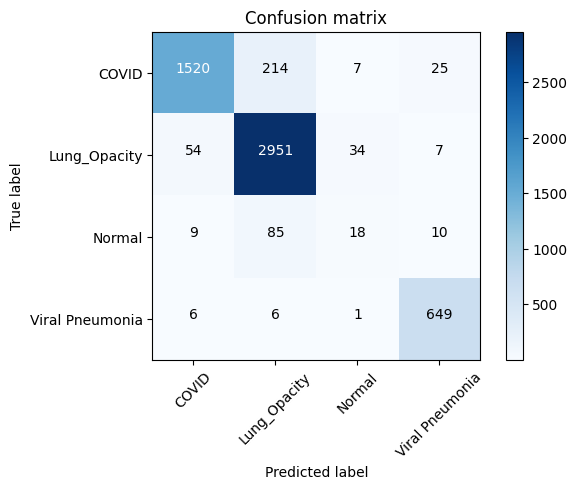

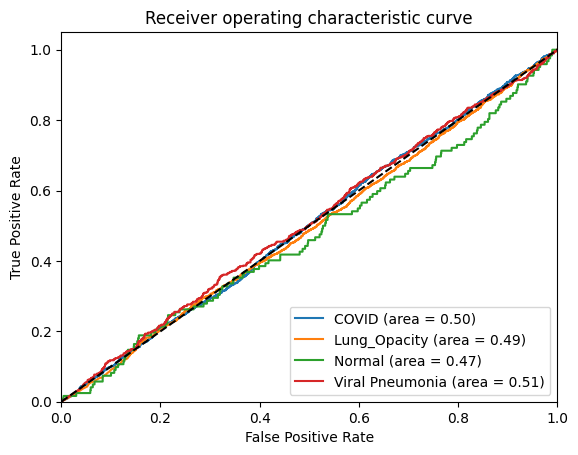

In [13]:

y_true = [] 
y_pred = [] 
with torch.no_grad(): 
    for data in testloader: 
        images, labels = data 
        images, labels=images.to(device),labels.to(device)
        outputs = net(images) 
        _, predicted = torch.max(outputs, 1) 
        y_true.extend(labels.cpu().numpy()) 
        y_pred.extend(predicted.cpu().numpy()) 

cm = metrics.confusion_matrix(y_true, y_pred)
print(cm) 

print(
        'classification report...\n{}'
        ''.format(classification_report(y_true=y_true, y_pred=y_pred))
    )


plt.imshow(cm, cmap=plt.cm.Blues) 
plt.title('Confusion matrix') 
plt.colorbar() 
tick_marks = np.arange(4) 
plt.xticks(tick_marks, classes, rotation=45) 
plt.yticks(tick_marks, classes) 

thresh = cm.max() / 2.
for i in range(cm.shape[0]): 
    for j in range(cm.shape[1]): 
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black") 
        

plt.tight_layout() 
plt.ylabel('True label') 
plt.xlabel('Predicted label') 
plt.show() 


y_score = [] 
with torch.no_grad(): 
    for data in testloader: 
        images, labels = data
        images, labels=images.to(device),labels.to(device)
        outputs = net(images) 
        outputs = torch.softmax(outputs, dim=1) 
        y_score.extend(outputs.cpu().numpy()) 

y_score = np.array(y_score) 
y_true = np.array(y_true)

fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(4): 
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i]) 

plt.figure() 
for i in range(4): 
    plt.plot(fpr[i], tpr[i], label='%s (area = %0.2f)' % (classes[i], roc_auc[i])) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Receiver operating characteristic curve') 
plt.legend(loc="lower right") 
plt.show() 